In [218]:
from scipy.linalg import expm
import numpy as np

class FockSpaceSimulator:

    def __init__(self, num_modes, max_occupancy):
        self.num_modes = num_modes
        self.max_occupancy = max_occupancy
        self.dim = (max_occupancy + 1) ** num_modes
        self.basis_states = self._generate_fock_basis()

    def _generate_fock_basis(self):
        """Generate all possible Fock states."""
        from itertools import product
        return np.array(list(product(range(self.max_occupancy + 1), repeat=self.num_modes)))

    def creation_operator(self, mode):
        """Return the creation operator for a specific mode."""
        op = np.zeros((self.dim, self.dim))
        for i, state in enumerate(self.basis_states):
            if state[mode] < self.max_occupancy:
                new_state = state.copy()
                new_state[mode] += 1
                j = self._state_index(new_state)
                op[j, i] = np.sqrt(new_state[mode])
        return op

    def annihilation_operator(self, mode):
        """Return the annihilation operator for a specific mode."""
        op = np.zeros((self.dim, self.dim))
        for i, state in enumerate(self.basis_states):
            if state[mode] > 0:
                new_state = state.copy()
                new_state[mode] -= 1
                j = self._state_index(new_state)
                op[j, i] = np.sqrt(state[mode])
        return op

    def _state_index(self, state):
        """Find the index of a state in the basis."""
        for i, basis_state in enumerate(self.basis_states):
            if np.array_equal(state, basis_state):
                return i
        raise ValueError("State not found in basis.")

    def construct_transverse_field_hamiltonian(self):
        """
        Construct the transverse field Hamiltonian in second quantization.
        This Hamiltonian corresponds to a uniform magnetic field in the x-direction.
        :return: The transverse field Hamiltonian matrix.
        """
        H_transverse = np.zeros((self.dim, self.dim), dtype=complex)
        for mode in range(self.num_modes):
            a_dagger = self.creation_operator(mode)
            a = self.annihilation_operator(mode)
            H_transverse += a + a_dagger  # X = a + a† in the Fock basis
        return H_transverse

    def evolve(self, initial_state, H_initial, H_final, T, steps=100):
        """
        Evolve the state under a time-dependent Hamiltonian from H_initial to H_final over time T.
        :param initial_state: Initial state vector.
        :param H_initial: Initial Hamiltonian (transverse field).
        :param H_final: Final Hamiltonian (problem Hamiltonian).
        :param T: Total evolution time.
        :param steps: Number of discrete time steps.
        :return: Final evolved state.
        """
        dt = T / steps
        state = initial_state
        states_over_time = []
        H_ts_over_time = []

        for step in range(steps):
            t = step * dt
            s = t / T  # Time-dependent parameter for interpolation
            H_t = (1 - s) * H_initial + s * H_final  # Interpolate Hamiltonian
            H_norm = np.linalg.norm(H_t)

            if H_norm > 0:
                H_t = H_t / H_norm  # Normalize Hamiltonian to prevent overflow
                dt_scaled = dt * H_norm
            else:
                dt_scaled = dt

            U = expm(-1j * H_t * dt_scaled)  # Evolution operator
            state = U @ state
            state /= np.linalg.norm(state)  # Normalize state to prevent numerical drift

            states_over_time.append((t, state))
            H_ts_over_time.append((t, H_t))

        return states_over_time, H_ts_over_time, state

    def suggest_t(self, H):
        """Suggest optimal time based on the Hamiltonian's energy gap."""
        eigenvalues = np.linalg.eigvalsh(H)
        gaps = np.diff(np.sort(eigenvalues))
        delta_E = np.min(gaps) if len(gaps) > 0 else 0
        if delta_E == 0:
            print("Warning: Minimum energy gap is zero. Using fallback time T = 1.")
            return 1.0  # Fallback time
        return self.num_modes / (delta_E ** 2)


In [209]:
class HaldaneShastrySecondQuantized:
    def __init__(self, num_modes, J0):
        """
        Initialize the Haldane-Shastry model in second quantized form.
        :param num_modes: Number of sites (modes).
        :param J0: Coupling constant J_0.
        """
        self.num_modes = num_modes
        self.J0 = J0
        self.edges = [(i, j) for i in range(num_modes) for j in range(i + 1, num_modes)]
        self.weights = {(i, j): J0 / (j - i) ** 2 for i, j in self.edges}

    def hamiltonian(self, simulator):
        """
        Construct the second quantized Hamiltonian.
        :param simulator: Instance of FockSpaceSimulator.
        :return: Hamiltonian matrix.
        """
        H = np.zeros((simulator.dim, simulator.dim), dtype=complex)

        # Number operators for each mode
        number_operators = [simulator.creation_operator(i) @ simulator.annihilation_operator(i)
                            for i in range(self.num_modes)]

        # Interaction terms
        for (i, j), J_ij in self.weights.items():
            n_i = number_operators[i]
            n_j = number_operators[j]

            # Add 4 J_ij n_i n_j term
            H += 4 * J_ij * n_i @ n_j

            # Subtract 2 J_ij (n_i + n_j) term
            H -= 2 * J_ij * (n_i + n_j)

            # Add J_ij constant term
            H += J_ij * np.eye(simulator.dim)

        return H

In [210]:
# Parameters for the Haldane-Shastry model
num_modes = 4  # Number of sites
J0 = 1.0  # Coupling constant

# Create Fock space simulator
max_occupancy = 1  # Single particle per site
simulator = FockSpaceSimulator(num_modes, max_occupancy)

# Initialize Haldane-Shastry model in second quantization
haldane_shastry = HaldaneShastrySecondQuantized(num_modes, J0)

# Define H_initial and H_final
H_initial = simulator.construct_transverse_field_hamiltonian()

# Construct the Hamiltonian
H = haldane_shastry.hamiltonian(simulator)

# Suggest optimal time
T = simulator.suggest_t(H)

# Initial state (equal superposition)
initial_state = np.ones(simulator.dim, dtype=complex) / np.sqrt(simulator.dim)

# Evolve the state
states_forward, H_ts_over_time, final_state = simulator.evolve(initial_state, H_initial, H, T)

print("Final State:", final_state)

Final State: [-0.33840198+0.13573426j -0.18882038-0.18965487j  0.00464523-0.20979437j
 -0.14841168-0.21831443j  0.00464523-0.20979437j  0.11330092-0.11252708j
  0.03941418-0.19749797j -0.18882038-0.18965487j -0.18882038-0.18965487j
  0.03941418-0.19749797j  0.11330092-0.11252708j  0.00464523-0.20979437j
 -0.14841168-0.21831443j  0.00464523-0.20979437j -0.18882038-0.18965487j
 -0.33840198+0.13573426j]


In [219]:
def measure(final_state, simulator, H, shots=10000):
    """
    Measure the final quantum state in the Fock basis and return the most frequent configuration and its energy.
    :param final_state: The final quantum state as a complex vector.
    :param simulator: The simulator instance.
    :param H: The Hamiltonian matrix.
    :param shots: Number of measurements to simulate.
    :return: The most frequently observed Fock state and its energy.
    """
    # Compute probabilities for each Fock state
    probabilities = np.abs(final_state) ** 2
    probabilities /= np.sum(probabilities)  # Normalize to ensure probabilities sum to 1

    # Perform sampling based on probabilities
    sampled_indices = np.random.choice(len(probabilities), size=shots, p=probabilities)

    # Count the occurrences of each index
    unique, counts = np.unique(sampled_indices, return_counts=True)
    most_frequent_index = unique[np.argmax(counts)]

    # Retrieve the most frequent Fock state
    most_frequent_state = simulator.basis_states[most_frequent_index]

    # Calculate the energy of the most frequent state
    energy = np.real(np.dot(
        np.conjugate(final_state[most_frequent_index]),
        H[most_frequent_index, most_frequent_index] * final_state[most_frequent_index]
    ))

    return most_frequent_state, energy


In [223]:
# Perform measurement
most_frequent_state, energy = measure(final_state, simulator, H)

print("Most Frequent State (Fock Basis):", most_frequent_state)
print("Energy of Most Frequent State:", energy)


Most Frequent State (Fock Basis): [1 1 1 1]
Energy of Most Frequent State: 14.294964380164853


In [217]:
def print_top_occupation_probabilities(final_state, simulator, top_n=5):
    """
    Print the top N occupation state probabilities from the final quantum state.
    :param final_state: The final quantum state as a complex vector.
    :param simulator: The simulator instance for energy calculation.
    :param top_n: Number of top probabilities to print.
    """
    # Compute probabilities for each configuration
    probabilities = np.abs(final_state)**2
    probabilities /= np.sum(probabilities)  # Normalize

    # Get indices sorted by probabilities in descending order
    sorted_indices = np.argsort(probabilities)[::-1]

    # Print the top N configurations
    print(f"Top {top_n} occupation state probabilities:")
    for rank in range(top_n):
        index = sorted_indices[rank]
        prob = probabilities[index]
        
        # Convert the index to an occupation configuration
        occupations = [(index >> i) & 1 for i in range(simulator.N)]

        # Create a state vector for energy calculation
        state_vector = np.zeros_like(final_state)
        state_vector[index] = 1.0
        
        # Calculate energy using the Hamiltonian matrix
        energy = np.vdot(state_vector, simulator.H @ state_vector).real

        print(f"Rank {rank + 1}: Occupations = {occupations}, Probability = {prob:.4f}, Energy = {energy:.4f}")

print_top_occupation_probabilities(final_state, sim, top_n=5)

Top 5 occupation state probabilities:
Rank 1: Occupations = [1, 1, 1, 1], Probability = 0.1429, Energy = 3.6111
Rank 2: Occupations = [1, 0, 1, 1], Probability = 0.1086, Energy = 1.3611
Rank 3: Occupations = [1, 1, 1, 0], Probability = 0.1021, Energy = 2.2500
Rank 4: Occupations = [0, 1, 1, 1], Probability = 0.0933, Energy = 2.2500
Rank 5: Occupations = [1, 1, 0, 1], Probability = 0.0810, Energy = 1.3611


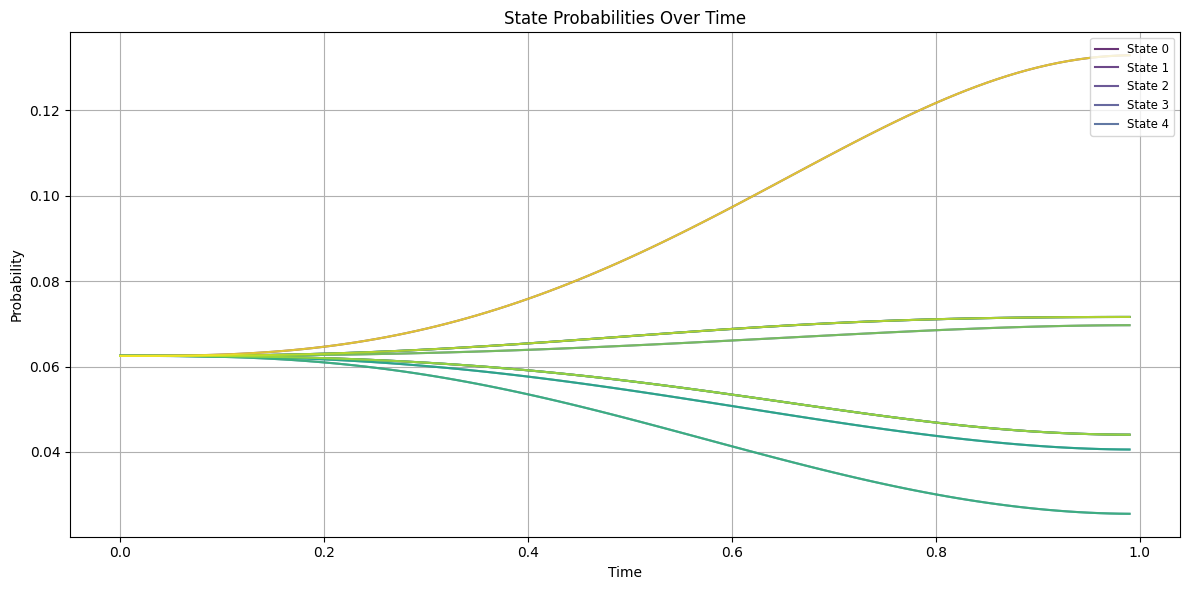

In [214]:
def plot_state_probabilities(states_over_time, classical_best=None):
    """
    Plots the evolution of state probabilities over time for the second quantization simulator.

    Parameters:
        states_over_time (list): List of tuples (time, state vector) from adiabatic evolution.
        classical_best (list): Classical best occupation (optional, to highlight its state).
    """
    num_states = len(states_over_time[0][1])
    probabilities_over_time = []
    time_points = []

    for t, state in states_over_time:
        probabilities = np.abs(state)**2
        probabilities_over_time.append(probabilities)
        time_points.append(t)

    probabilities_over_time = np.array(probabilities_over_time)
    time_points = np.array(time_points)

    # Plot state probabilities
    plt.figure(figsize=(12, 6))
    colors = cm.viridis(np.linspace(0, 1, num_states))

    for state_idx in range(num_states):
        plt.plot(
            time_points,
            probabilities_over_time[:, state_idx],
            color=colors[state_idx],
            alpha=0.8,
            label=f"State {state_idx}" if state_idx < 5 else None,  # Label first 5 states
        )

    # Highlight classical best occupation (if provided)
    if classical_best is not None:
        classical_index = sum((1 << i) * b for i, b in enumerate(classical_best))
        plt.plot(
            time_points,
            probabilities_over_time[:, classical_index],
            color="red",
            alpha=1.0,
            linewidth=2,
            label=f"Classical Best: {classical_best}",
        )

    plt.title("State Probabilities Over Time")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.legend(loc="upper right", fontsize="small")
    plt.tight_layout()
    plt.show()

plot_state_probabilities(states_forward)

In [215]:
# Instantiate the simulator and Haldane-Shastry model
num_modes = 4
J0 = 1.0
max_occupancy = 1
simulator = FockSpaceSimulator(num_modes, max_occupancy)
haldane_shastry = HaldaneShastrySecondQuantized(num_modes, J0)

# Construct the Hamiltonian
H = haldane_shastry.hamiltonian(simulator)

# Validate Hermiticity
assert np.allclose(H, H.conj().T), "Hamiltonian is not Hermitian!"

# Diagonalize the Hamiltonian
eigenvalues, eigenvectors = np.linalg.eigh(H)

# Print the lowest energy state
ground_state_index = np.argmin(eigenvalues)
ground_state = eigenvectors[:, ground_state_index]

print("Ground State Energy:", eigenvalues[ground_state_index])
print("Ground State Vector (Fock Basis):", ground_state)

# Verify expected configurations
probabilities = np.abs(ground_state)**2
for i, prob in enumerate(probabilities):
    if prob > 1e-2:  # Threshold to identify significant states
        print(f"Fock State {simulator.basis_states[i]}: Probability {prob:.4f}")


Ground State Energy: -2.611111111111111
Ground State Vector (Fock Basis): [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Fock State [0 1 0 1]: Probability 1.0000


In [220]:
class NumberPartitioningSecondQuantized:

    def __init__(self, numbers):
        self.numbers = numbers
        self.num_modes = len(numbers)

    def hamiltonian(self, simulator):
        """
        Construct the second quantized Hamiltonian for the Number Partitioning problem.
        :param simulator: Instance of FockSpaceSimulator.
        :return: Hamiltonian matrix.
        """
        H = np.zeros((simulator.dim, simulator.dim), dtype=complex)

        # Number operators for each mode
        number_operators = [simulator.creation_operator(i) @ simulator.annihilation_operator(i)
                            for i in range(self.num_modes)]

        # Construct the Hamiltonian
        for i in range(self.num_modes):
            for j in range(self.num_modes):
                H += self.numbers[i] * self.numbers[j] * number_operators[i] @ number_operators[j]

        return H


In [222]:
numbers = [3, 1, 4, 2]  # Example list of numbers

# Initialize the Fock space simulator
num_modes = len(numbers)
max_occupancy = 1  # Single particle per site
simulator = FockSpaceSimulator(num_modes, max_occupancy)

# Initialize the Number Partitioning model in second quantization
number_partitioning = NumberPartitioningSecondQuantized(numbers)

# Construct the second quantized Hamiltonian
H_final = number_partitioning.hamiltonian(simulator)

# Define H_initial and H_final
H_initial = simulator.construct_transverse_field_hamiltonian()

# Suggest optimal time
T = simulator.suggest_t(H_final)

# Initial state (equal superposition)
initial_state = np.ones(simulator.dim, dtype=complex) / np.sqrt(simulator.dim)

# Evolve the state
states_forward, H_ts_over_time, final_state = simulator.evolve(initial_state, H_initial, H, T)

print("Final State:", final_state)

Final State: [ 0.01445671-0.15106981j -0.16824827+0.02112953j -0.14505283-0.09060783j
  0.22466966+0.0564974j  -0.03119259-0.13992131j  0.17683975+0.16696267j
  0.1954156 -0.15274117j  0.31687597+0.0409222j   0.1317394 +0.11473151j
  0.18254714-0.14388503j  0.22307658+0.03514994j -0.28381545-0.02181565j
 -0.21078657-0.12707345j  0.3216579 +0.07193443j  0.17355929-0.25126543j
  0.37598652+0.03979678j]
